In [2]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

from scripts import datasources, models, variables

import seaborn as sns

In [3]:
%%capture
orca.run(['initialize_network_small', 'network_aggregations_small'])

In [4]:
%%capture
orca.run(['initialize_network_walk','network_aggregations_walk'])

In [2]:
orca.list_broadcasts()

[('parcels', 'buildings'),
 ('buildings', 'units'),
 ('units', 'households'),
 ('households', 'persons'),
 ('buildings', 'jobs'),
 ('nodeswalk', 'parcels'),
 ('nodeswalk', 'rentals'),
 ('nodessmall', 'rentals'),
 ('nodessmall', 'parcels')]

In [4]:
for table_name in orca.list_tables():
    print(table_name.upper())
    print(orca.get_table(table_name).to_frame().columns.tolist())
    print()

PARCELS
['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id', 'proportion_undevelopable', 'tax_exempt_status', 'apn', 'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area', 'block_id', 'node_id', 'node_id_small', 'node_id_walk']

BUILDINGS
['parcel_id', 'development_type_id', 'improvement_value', 'residential_units', 'residential_sqft', 'sqft_per_unit', 'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type', 'costar_property_type', 'costar_rent', 'building_type_id', 'res_sqft_per_unit', 'node_id_small', 'node_id_walk']

CRAIGSLIST
['date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft', 'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state', 'bathrooms']

RENTALS
['Unnamed: 0', 'date', 'region', 'neighborhood', 'rent', 'bedrooms', 'sqft', 'rent_sqft', 'longitude', 'latitude', 'county', 'fips_block', 'state', 'bathro

In [6]:
orca.get_table('households').to_frame().describe()

,serialno,persons,building_type,cars,income,race_of_head,age_of_head,workers,children,tenure,recent_mover,unit_id,building_id,node_id_small,node_id_walk
count,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.677468e+06,2.487699e+06,2.487699e+06
mean,2.011048e+12,2.637121e+00,3.586621e+00,1.882801e+00,1.131284e+05,2.837879e+00,5.296986e+01,1.302752e+00,5.626338e-01,1.426969e+00,3.883258e-02,1.288427e+06,8.580958e+05,7.858688e+08,1.147092e+09
std,1.416906e+09,1.573306e+00,2.335401e+00,1.139782e+00,1.079526e+05,2.662159e+00,1.568676e+01,9.979341e-01,9.710445e-01,4.946378e-01,1.931958e-01,8.497798e+05,5.611658e+05,1.387440e+09,1.823692e+09
min,2.009000e+12,1.000000e+00,1.000000e+00,0.000000e+00,-1.160000e+04,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,2.812660e+05,2.602875e+07
25%,2.010000e+12,1.000000e+00,2.000000e+00,1.000000e+00,4.032000e+04,1.000000e+00,4.100000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,5.409708e+05,3.599548e+05,5.793848e+07,5.794183e+07
50%,2.011001e+12,2.000000e+00,2.000000e+00,2.000000e+00,8.400000e+04,1.000000e+00,5.300000e+01,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.272990e+06,8.378585e+05,6.550151e+07,6.556870e+07
75%,2.012001e+12,4.000000e+00,5.000000e+00,2.000000e+00,1.501000e+05,6.000000e+00,6.300000e+01,2.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,2.024749e+06,1.341263e+06,6.141410e+08,1.304953e+09
max,2.013001e+12,2.000000e+01,1.000000e+01,6.000000e+00,1.397000e+06,9.000000e+00,9.400000e+01,1.300000e+01,9.000000e+00,2.000000e+00,1.000000e+00,2.781489e+06,1.843272e+06,5.458527e+09,5.471137e+09


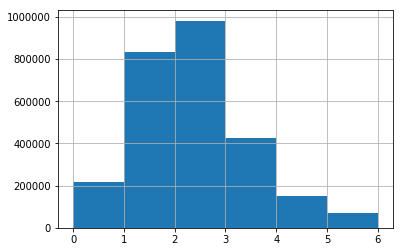

In [7]:
# explanatory analysis
orca.get_table('households').to_frame()['cars'].hist(bins = int(max(orca.get_table('households').to_frame()['cars'])))
# makes sense to create four options: 0-car, 1-car, 2-car, 2+

In [5]:
cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
orca.add_column('households', 'cars_alt', cars_alt)

has_car = (orca.get_table('households').to_frame()['cars']>0).astype(int)
orca.add_column('households','has_car',has_car)

In [5]:
persons = orca.get_table('persons').to_frame()
persons['above_60'] = (persons['age']>60).astype(int)
above_60 = persons.groupby('household_id')['above_60'].max()
# has_selfemploy = persons.groupby('household_id')['work_at_home'].max()


In [15]:
orca.add_column('households','above_60',above_60)

In [10]:
df = orca.merge_tables(target = 'households',tables = ['households','units','buildings'])
bdtype_dummies = pd.get_dummies(df['building_type'].astype(int),prefix='building_type_is')
race_dummies = pd.get_dummies(df['race_of_head'],prefix = 'race')
tenure_dummies = pd.get_dummies(df['tenure'],prefix = 'tenure')
df_corr = df[['persons','has_car','cars_alt','income','age_of_head',
              'workers','children','recent_mover','single_family',
         'sqft_per_unit','stories',
            #  'above_60'
             ]]
df_corr = pd.concat([df_corr,
    bdtype_dummies,race_dummies,tenure_dummies],
axis = 1)

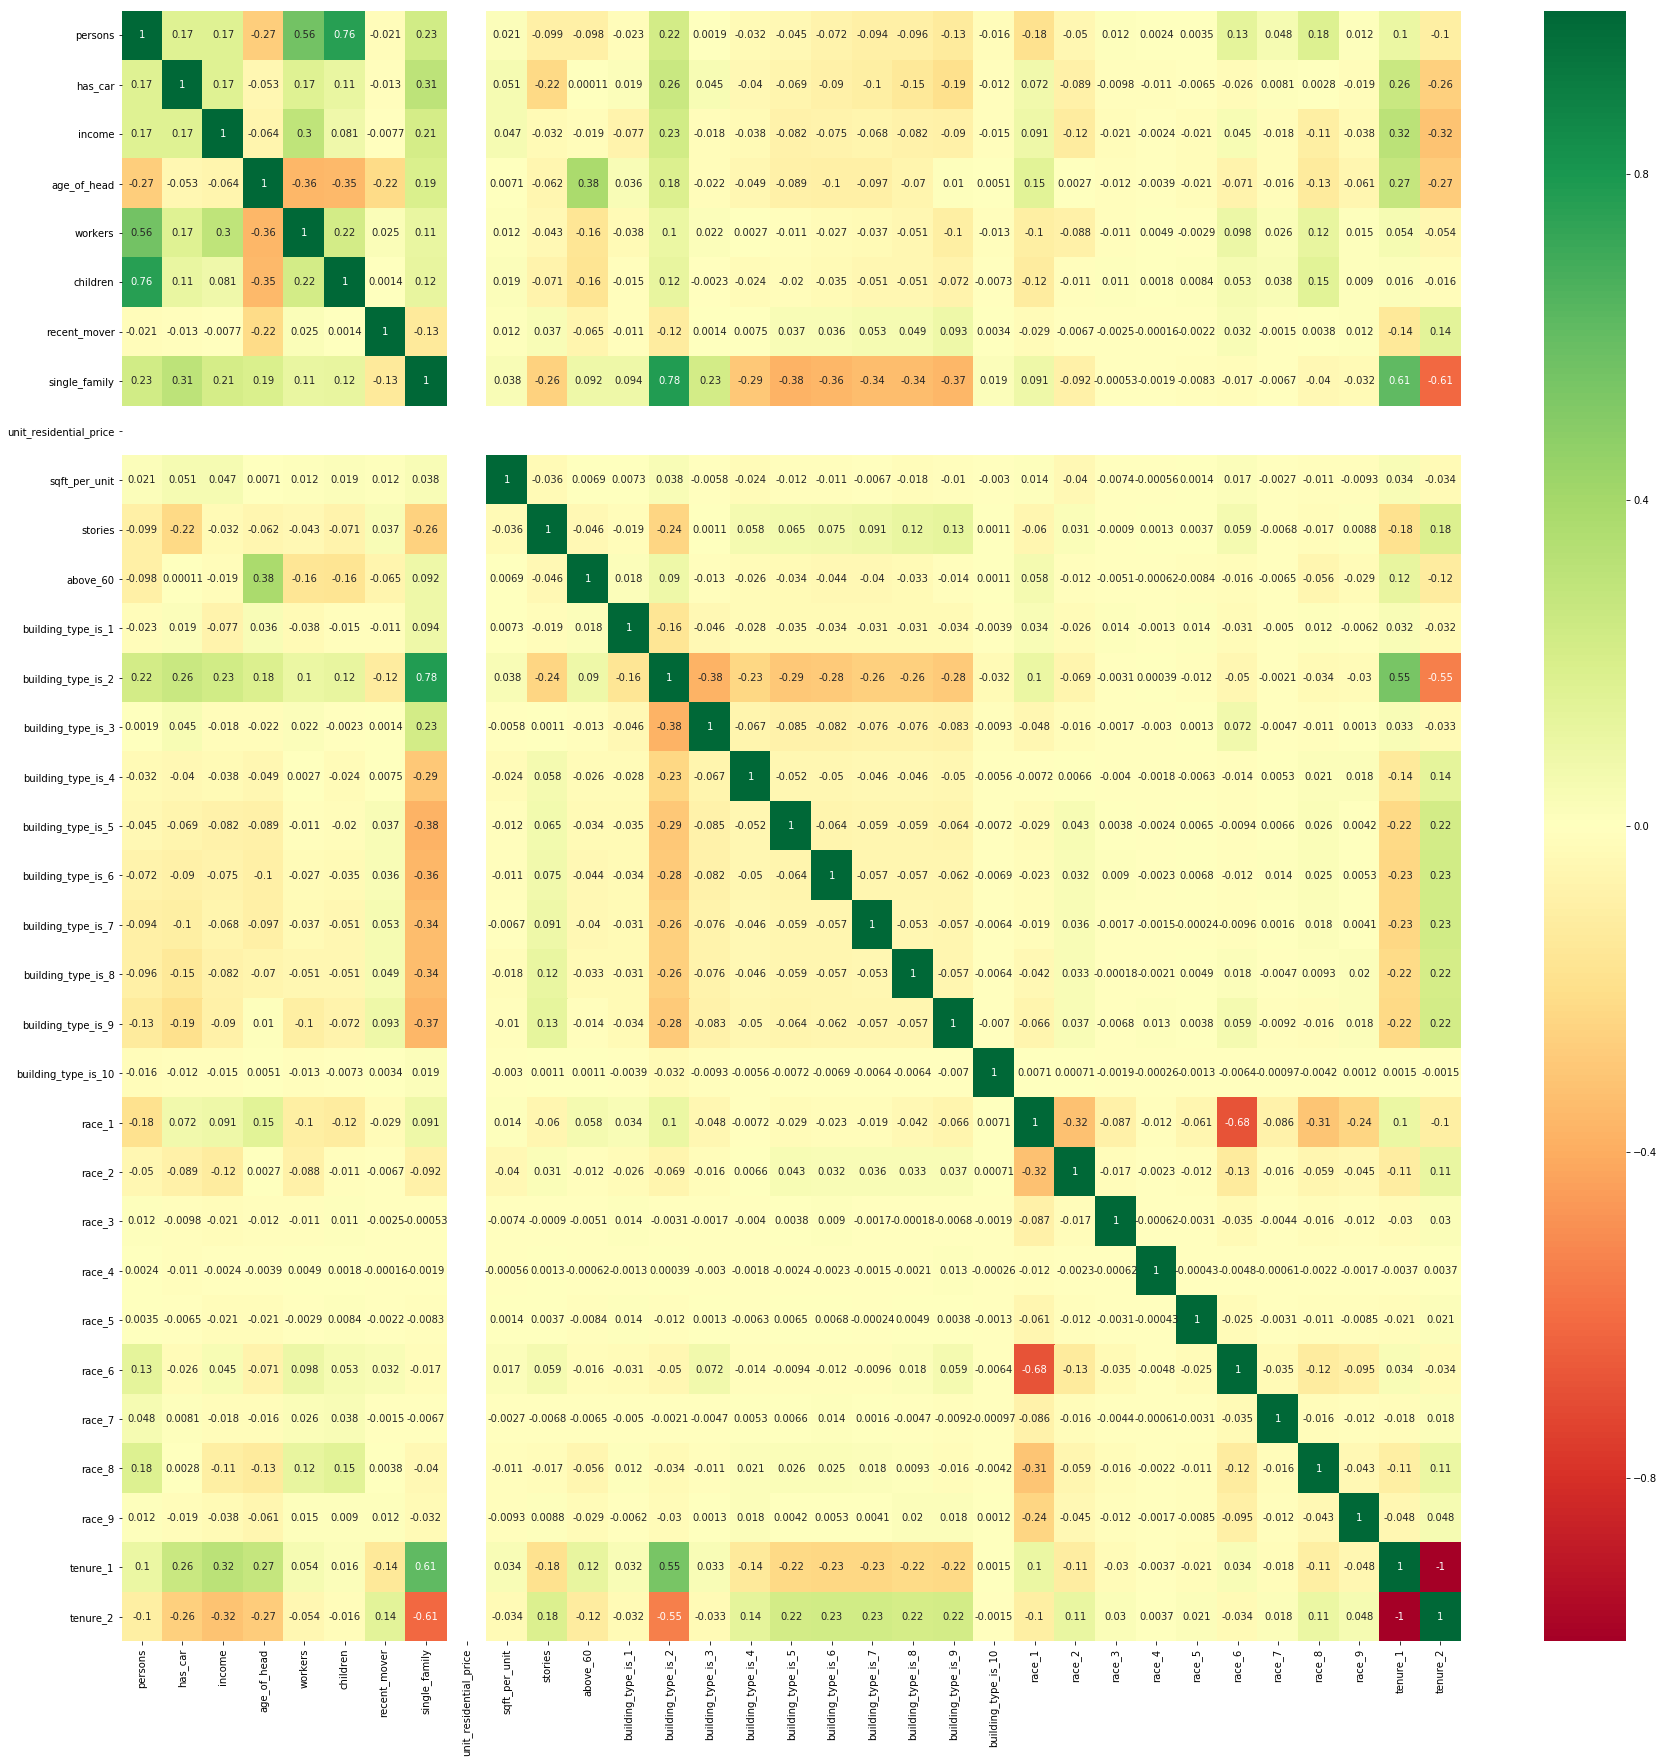

In [19]:

plt.subplots(figsize=(30, 30))
sns.heatmap(df_corr.corr(), annot=True, cmap="RdYlGn")

In [5]:
m = SmallMultinomialLogitStep()
m.name = 'auto_ownership'

In [15]:
m.tables = ['households'
         ,'units','buildings','parcels' ,'nodessmall','nodeswalk'
           ]
m.choice_column = 'cars_alt'

In [6]:
# log income column
income_log =orca.get_table('households').to_frame()['income'].apply(lambda x:  np.log(x) if x > 0 else 0)

# income bins
income_bins = pd.cut(orca.get_table('households').to_frame().income,
      bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
      labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
for i in income_bin_dummies.columns:
    orca.add_columns('households',i,income_bin_dummies[i])

orca.add_column('households', 'income_log', income_log)

# tenure type dummy
orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# single family as integer
orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# building type dummy
orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [17]:
m.model_expression = OrderedDict([
    ('intercept', [1,2,3]),        
    ('income_log', [1,2,3]),
    ('persons', [0,1,2]),
    ('age_of_head',[1,2,3]),
    ('workers',[1,2,3]),
    ('children',[1,2,3]),
    ('single_family_int',[1,2,3]),
    ('tenure_1',[[1,2,3]]),

  #  ('units_500_walk',[0]),
  #  ('pop_500_walk',[0]),
  #  ('renters_500_walk',[0]),
  #  ('avg_rent_500',[0]),
   # ('jobs_500_walk_retail',[0]),

     ])



In [9]:
chooser_ids = orca.get_table('households').to_frame().sample(15000,random_state = 2).index.values # sample 15000 based on household ID
m.filters = ['household_id in [{0}]'.format(','.join(map(str, chooser_ids)))]

In [ ]:
m.fit()
#print(m.summary_table)

Log-likelihood at zero: -20,794.4154
Initial Log-likelihood: -20,794.4154
Estimation Time for Point Estimation: 1.45 seconds.
Final log-likelihood: -14,779.5750


In [ ]:
m.name = 'auto-ownership'
m.tags = ['auto','auto ownership','jayne','test']
m.register()

In [ ]:
# with accessibility tables [this fails]

In [20]:
m1 = SmallMultinomialLogitStep()
m1.name = 'auto_ownership_acc'

In [ ]:
## m1.tables = ['households'
         ,'units','buildings','parcels','nodessmall','nodeswalk'
            ]
m1.choice_column = 'cars_alt'


In [29]:
m1.model_expression = OrderedDict([
    ('intercept', [1,2,3]),        
    ('income_log', [1,2,3]),
    ('persons', [0,1,2]),
    ('age_of_head',[1,2,3]),
    ('workers',[1,2,3]),
    ('children',[1,2,3]),
    ('single_family_int',[1,2,3]),
    ('tenure_1',[[1,2,3]]),
    ('units_500_walk',[0]),
    ('pop_500_walk',[0]),
    ('renters_500_walk',[0]),
    ('jobs_500_walk_retail',[0]),

     ])



In [23]:
m1.filters = ['household_id in [{0}]'.format(','.join(map(str, chooser_ids)))]

In [48]:
m1.fit()
#print(m.summary_table)

RuntimeError: Not all required columns were found. Missing: ['household_id']

In [7]:
# distance to bart
bart = pd.read_csv('./gtfs/stops.txt')[['stop_id','stop_lat','stop_lon']]

In [8]:
import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

crs_wgs = proj.Proj(init='epsg:4326')
crs_wcal = proj.Proj(init='epsg:32610')
crs_ecal = proj.Proj(init='epsg:32611')

def make_proj_point(lon,lat):
    coord_tuple = (lon,lat)
    if coord_tuple[0]<-120:
        crs = crs_wcal
    else: crs = crs_ecal
    try: pt = geometry.Point(proj.transform(crs_wgs, crs, *coord_tuple))
    except: pt = None
    return pt

def stop_to_list(gtfs):
    l = []
    for idx, row in gtfs.iterrows():
        pt = make_proj_point(row.stop_lon,row.stop_lat)
        l.append(pt)
    return l

def has_bart(row):
    if row['in_bart_counties']:
        pt = make_proj_point(row.x,row.y)
        s = 0
        for stop in stop_list:
            if (pt.distance(stop)<402): # a quarter mile
                return 1 
        return s
    else:
        return 0

In [9]:
stop_list = stop_to_list(bart)
parcels = orca.get_table('parcels').to_frame()

In [10]:
parcels['in_bart_counties'] = parcels['county_id'].isin([1,13,75])
parcels_has_bart= parcels.apply(has_bart,axis = 1)

In [44]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])

In [12]:
orca.add_column('parcels','has_bart',parcels_has_bart)

In [46]:
@orca.table(cache=True)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels','nodeswalk','nodessmall'])
    return df

In [ ]:
# hh with accessibility tables joined outside the model [this works]

In [47]:
m2 = SmallMultinomialLogitStep()
m2.name = 'auto_ownership_acc2'

In [48]:
m2.tables = ['hh_merged']
m2.choice_column = 'cars_alt'


In [54]:
m2.model_expression = OrderedDict([
    ('intercept', [1,2,3]),        
    ('income_log', [1,2,3]),
    ('persons', [0,1,2]),
    ('age_of_head',[1,2,3]),
    ('workers',[1,2,3]),
    ('children',[1,2,3]),
    ('single_family_int',[1,2,3]),
    ('tenure_1',[[1,2,3]]),
    ('units_500_walk',[1,2,3]),
    ('pop_500_walk',[1,2,3]),
    ('renters_500_walk',[1,2,3]),
    ('has_bart',[[1,2,3]]),
    ('county_1',[[1,2,3]]),
     ('county_13', [[1,2,3]]),
      ('county_41', [[1,2,3]]),
     ('county_55',[[1,2,3]]),
     ('county_75', [[1,2,3]]),
     ('county_97',[[1,2,3]]),
     ])



In [50]:
chooser_ids = orca.get_table('households').to_frame().sample(15000,random_state = 2).index.values # sample 15000 based on household ID

m2.filters = ['household_id in [{0}]'.format(','.join(map(str, chooser_ids)))]

In [55]:
m2.fit()

Log-likelihood at zero: -19,327.7160
Initial Log-likelihood: -19,327.7160
Estimation Time for Point Estimation: 1.44 seconds.
Final log-likelihood: -13,343.6222
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:               13,942
Model:             Multinomial Logit Model   Df Residuals:                   13,904
Method:                                MLE   Df Model:                           38
Date:                     Fri, 28 Sep 2018   Pseudo R-squ.:                   0.310
Time:                             18:16:49   Pseudo R-bar-squ.:               0.308
AIC:                            26,763.244   Log-Likelihood:            -13,343.622
BIC:                            27,049.865   LL-Null:                   -19,327.716
                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [56]:
# Try decision tree.
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf0 = DecisionTreeClassifier(random_state = 0)
df = orca.get_table('hh_merged').to_frame().sample(15000,random_state = 2)



In [81]:
X0 = df[['income_log','persons','age_of_head','workers','children',
         'single_family_int','tenure_1','units_500_walk','pop_500_walk',
        'renters_500_walk','has_bart',
         'county_1', 'county_13', 'county_41', 'county_55',
       'county_75', 'county_81', 'county_85', 'county_95', 'county_97'
        ]]

y = df['cars_alt']
print(cross_val_score(clf0, X0, y, cv=4))


[0.54793609 0.57256991 0.53129161 0.54327563 0.54266667 0.53266667
 0.5293725  0.52069426 0.54672897 0.54672897]


In [59]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
clf1 = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)

In [82]:
print(cross_val_score(clf1, X0, y, cv=4))

[0.55925433 0.54194407 0.5539281  0.55725699 0.54866667 0.57266667
 0.53671562 0.53204272 0.54205607 0.56742323]
